# Synthetic expression data from asynchronous random walks on star network

In this series of notebooks, we demonstrate how scBoolSeq can be employed to generate synthetic scRNA-Seq datasets from Boolean states of trajectories of mechanistic Boolean models.

This notebook focuses on a toy model where a transcription factor progressively activates its target genes.

In [1]:
import pandas as pd
import numpy as np
import random
from colomoto.minibn import * # for Boolean network manipulation
from scboolseq import scBoolSeq

# set seed for reproducible results
_rng_seed = 19834650
# use a Generator instead of numpy's singleton
_rng = np.random.default_rng(_rng_seed)
random.seed(_rng_seed)

This notebook has been executed using the docker image `bnediction/scboolseq:v0`

## Load Boolean network model

In [2]:
bn = BooleanNetwork.load("models/star.bnet")
bn

gene1 <- tf
gene10 <- tf
gene2 <- tf
gene3 <- tf
gene4 <- tf
gene5 <- tf
gene6 <- tf
gene7 <- tf
gene8 <- tf
gene9 <- tf
tf <- 1

# computing graph layout...


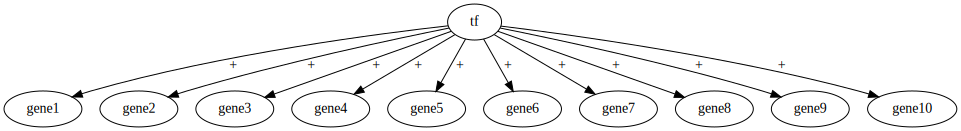

In [3]:
bn.influence_graph()

## Simulation with random walk

With the asynchronous update mode, the activation of the genes can be made in any order. Here, we randomly sample one trajectory of this model, which essentially boils down to selecting a random ordering of genes that get activated.

Let us first specify the initial state of the network:

In [4]:
initial_state = bn.zero()
initial_state["tf"] = 1
initial_state

{'tf': 1,
 'gene1': 0,
 'gene2': 0,
 'gene3': 0,
 'gene4': 0,
 'gene5': 0,
 'gene6': 0,
 'gene7': 0,
 'gene8': 0,
 'gene9': 0,
 'gene10': 0}

Then, we use `minibn` to generate a random walk in the asynchronous dynamics of the Boolean network from the given initial state:

In [5]:
dynamics = FullyAsynchronousDynamics(bn)
random_walk_df = pd.DataFrame(dynamics.random_walk(initial_state, steps=10))
random_walk_df

,tf,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0
2,1,1,0,0,0,0,0,0,1,0,0
3,1,1,0,1,0,0,0,0,1,0,0
4,1,1,0,1,0,0,1,0,1,0,0
5,1,1,0,1,0,0,1,0,1,1,0
6,1,1,0,1,0,0,1,0,1,1,1
7,1,1,0,1,1,0,1,0,1,1,1
8,1,1,1,1,1,0,1,0,1,1,1
9,1,1,1,1,1,0,1,1,1,1,1


## Retrieve statistics of real expression datasets

In order to generate synthetic RNA counts, scBoolSeq relies on statistical criteria learnt from real scRNA-Seq datasets. Then, the nodes of the Boolean model used to generate the Boolean states need to be associated with real gene names: scBoolSeq will then generate RNA counts from the corresponding distribution, biased by the Boolean state of the gene.

In this example, we re-use the simulation criteria learnt from the Nestorowa dataset in the [1 - Binarization and synthetic data generation](1%20-%20Binarization%20and%20synthetic%20data%20generation.ipynb) notebook:

In [6]:
criteria = pd.read_csv("cache_scBoolSeq_Nestorowa_simulation_criteria.csv", index_col=0)
criteria.head()

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category,dor_threshold
Clec1b,9.948487e-01,1.635698,6.166711,0.876208,1.520978,-0.007249,8.852181,0.986140,0.013860,0.111291,5.666490,0.157649,1.520978,2.666760,0.25,0.667271,1.555290,0.888020,0.968776,2.785740,3.094168,Unimodal,NaN
Kdm3a,0.000000e+00,2.407548,-0.784019,0.326087,3.847940,0.209239,10.126676,0.714520,0.285480,0.872643,6.899449,1.278247,2.593177,8.692586,0.25,0.000000,5.258984,5.258984,1.268040,3.432251,4.748643,Bimodal,0.95
Coro2b,4.684039e-03,2.320060,0.327060,0.658213,2.383819,0.004597,9.475577,0.919508,0.080492,0.335546,6.289079,0.487372,2.383819,5.370521,0.25,0.827740,2.912944,2.085205,1.290666,3.183596,3.879537,Bimodal,NaN
8430408G22Rik,7.236739e-08,3.121069,-0.993979,0.884058,2.983472,0.005663,9.067857,0.964962,0.035038,0.098898,7.148808,0.172506,2.983472,8.154647,0.25,0.825298,6.465074,5.639776,1.449779,3.612061,4.175572,Bimodal,NaN
Clec9a,1.000000e+00,2.081717,140.089285,0.965580,2.280293,-0.009361,9.614233,0.993961,0.006039,0.035599,7.138099,0.069870,0.078488,0.372878,0.25,0.000000,0.000000,0.000000,0.000000,3.113410,4.607253,Discarded,0.95


In [7]:
criteria.Category.value_counts()

Bimodal      2987
Unimodal     1580
Discarded     201
Name: Category, dtype: int64

We randomly select bimodal genes for each of the nodes of the Boolean model to obtain simulation criteria:

In [8]:
random_criteria = criteria[
    (criteria.Category == "Bimodal") &
    (criteria.DropOutRate < 0.05)
].sample(11, random_state=_rng_seed)
random_criteria.set_index(random_walk_df.columns, inplace=True)
random_criteria

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category,dor_threshold
tf,0.000250,1.982430,-1.118390,0.027778,4.454848,2.231509,10.458465,0.634321,0.365679,2.449688,7.594680,1.562365,4.331102,7.707162,0.25,2.070391,6.920502,4.850112,3.321480,4.277351,6.081385,Bimodal,0.95
gene1,0.000000,2.171544,-1.148314,0.021135,6.223047,8.243204,11.193184,0.363906,0.636094,2.579439,8.100760,1.496439,6.091521,8.558219,0.25,3.183970,8.483865,5.299895,7.282884,4.384796,5.990926,Bimodal,0.95
gene2,0.000000,1.957530,-1.273249,0.044082,5.641087,8.029818,10.794851,0.409065,0.590935,2.258246,7.561991,1.774518,5.392416,8.579517,0.25,2.585510,7.994901,5.409391,6.129123,3.802762,5.780924,Bimodal,0.95
gene3,0.000000,2.123630,-1.315039,0.036836,5.724870,8.076334,10.811316,0.400338,0.599662,2.237126,7.701644,1.589570,5.513990,8.763508,0.25,2.536712,8.106769,5.570057,6.452676,3.963904,5.713590,Bimodal,0.95
gene4,0.000000,2.161170,-1.344687,0.018116,6.559400,9.543728,12.260558,0.403231,0.596769,2.734372,8.944811,1.987133,6.440570,11.275156,0.25,3.109483,9.439844,6.330361,7.471017,4.771986,6.660780,Bimodal,0.95
gene5,0.000000,2.167416,-1.386505,0.038647,5.661639,8.154579,10.498523,0.436231,0.563769,2.322133,7.857554,1.604112,5.442832,9.145257,0.25,2.480269,8.141719,5.661451,6.272476,4.156733,5.870370,Bimodal,0.95
gene6,0.000000,2.355317,-1.505761,0.034420,5.745117,8.722360,11.401288,0.433551,0.566449,2.015794,8.250379,1.720748,5.547368,11.273438,0.25,2.068712,8.581835,6.513123,6.533317,4.226884,5.879037,Bimodal,0.95
gene7,0.000000,2.307954,-0.861903,0.005435,6.800339,8.655035,10.931065,0.303185,0.696815,2.875043,8.455204,1.234993,6.763381,7.818094,0.25,4.108445,8.919568,4.811123,7.855844,4.817005,6.135923,Bimodal,0.95
gene8,0.000000,2.296122,-1.483351,0.043478,5.821394,8.961177,11.437198,0.489454,0.510546,2.422383,8.584236,1.799614,5.568290,11.294318,0.25,2.438392,8.763361,6.324968,5.836308,4.631891,6.354470,Bimodal,0.95
gene9,0.001038,1.593895,0.246388,0.035628,4.116075,3.382096,10.321775,0.813953,0.186047,3.118572,7.691919,1.246723,3.969428,4.416692,0.25,2.683685,4.560455,1.876770,3.506317,4.993969,6.611602,Bimodal,0.95


## Generate synthetic RNA-Seq data

We instantiate scBoolSeq with the simulation criteria having the name matching with the column of the generated Boolean matrix.

In [9]:
scbool = scBoolSeq(simulation_criteria=random_criteria)
scbool

scBoolSeq(has_data=False, can_binarize=False, can_simulate=True)

Then, we generate 300 samples per Boolean states using the `.simulate` method:

In [10]:
n_samples = 300 # number of samples per row

In [11]:
counts = scbool.simulate(random_walk_df, n_samples=n_samples)
counts.head()

,tf,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10
0,7.343997,4.423748,1.455764,2.666266,3.622463,2.339183,3.145557,2.355520,4.226817,2.450700,4.954449
1,6.503459,4.869516,0.997902,2.490826,3.831914,2.904771,1.355320,2.121728,9.014141,4.112613,2.857409
2,7.194568,8.060726,1.803331,3.395802,2.964298,2.039039,2.856274,3.078402,10.793265,2.710345,1.965232
3,5.265355,7.646248,1.637069,6.712579,3.382125,2.334264,0.000000,1.165221,9.365778,2.665426,6.474557
4,7.519443,8.754864,2.471689,7.591701,3.109703,2.208982,7.996878,1.137108,10.456507,2.603011,4.516670


To ease post-analysis with STREAM, we generate unique identifiers for each simulated row (cell):

In [12]:
ids = [f"step{x}_{y}"  for y in range(n_samples) for x in random_walk_df.index]
counts.index = ids
counts.index.name = "cellID"
counts

,tf,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10
cellID,,,,,,,,,,,
step0_0,7.343997,4.423748,1.455764,2.666266,3.622463,2.339183,3.145557,2.355520,4.226817,2.450700,4.954449
step1_0,6.503459,4.869516,0.997902,2.490826,3.831914,2.904771,1.355320,2.121728,9.014141,4.112613,2.857409
step2_0,7.194568,8.060726,1.803331,3.395802,2.964298,2.039039,2.856274,3.078402,10.793265,2.710345,1.965232
step3_0,5.265355,7.646248,1.637069,6.712579,3.382125,2.334264,0.000000,1.165221,9.365778,2.665426,6.474557
step4_0,7.519443,8.754864,2.471689,7.591701,3.109703,2.208982,7.996878,1.137108,10.456507,2.603011,4.516670
...,...,...,...,...,...,...,...,...,...,...,...
step6_299,7.019498,11.833026,4.191677,7.636880,4.569541,2.178149,8.812244,2.681519,8.103503,8.350228,8.577708
step7_299,6.869362,8.494998,0.987528,6.191569,8.565168,1.742142,7.830821,0.221380,10.301637,4.230131,7.762939
step8_299,9.318526,8.263307,5.660365,6.102051,8.717069,4.543780,6.495120,2.918222,8.388695,6.171941,4.913572


We write the result as a TSV file:

In [13]:
counts.T.to_csv("synthetic_data_star_counts.tsv", sep="\t")

The, we generate metadata to validate the trajectory reconstruction with STREAM:

In [14]:
nb_active_genes = [cfg.sum()-1 for _, cfg in random_walk_df.iterrows()]
_RGB_values = list("0123456789ABCDEF")
color_map = {nb: "#"+''.join([_rng.choice(_RGB_values) for _ in range(6)]) for nb in set(nb_active_genes)}
color_map

{0: '#A2F37E',
 1: '#36873F',
 2: '#81D278',
 3: '#8CA2D4',
 4: '#D0327B',
 5: '#CDEF47',
 6: '#CB6896',
 7: '#590605',
 8: '#3C27AB',
 9: '#4A7BBC',
 10: '#F0F94B'}

In [15]:
metadata = [[nb, color_map[nb]] for nb in nb_active_genes]*n_samples
metadata = pd.DataFrame(metadata, columns=["label", "label_color"])
metadata.index = counts.index
metadata

,label,label_color
cellID,,
step0_0,0,#A2F37E
step1_0,1,#36873F
step2_0,2,#81D278
step3_0,3,#8CA2D4
step4_0,4,#D0327B
...,...,...
step6_299,6,#CB6896
step7_299,7,#590605
step8_299,8,#3C27AB


In [16]:
metadata.to_csv("synthetic_data_star_metadata.tsv", sep="\t")

STREAM analysis is performed in a separate notebook: [3.1 - STREAM - Trajectory reconstruction for star network synthetic scRNA data](3.1%20-%20STREAM%20-%20Trajectory%20reconstruction%20for%20star%20network%20synthetic%20scRNA%20data.ipynb). Note that its execution should be performed in the adequate software environment (e.g., STREAM Docker image)